In [2]:
import os
import time
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, stft
from scipy.fft import fft
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve 

In [4]:
def cria_curva_roc_auc(modelo,df_verificacao,df_target):
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions[:,1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS')
    plt.legend(loc="lower right")
    plt.show()
    
def limiar_escore(modelo,df_verificacao,df_target):
    #Imprimindo limiar de Escore
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions[:,1]]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)
    print('Roc-AUC', roc_auc_score(df_target, predictions[:,1]))

# Functions

In [5]:
def plot_eeg(df, name='', save=False):
    fig, rows = plt.subplots(nrows=4, sharex=True, figsize=(17,10))
    fig.patch.set_visible(False)
    fig.tight_layout()

    for ax, col in zip(rows, df.columns):
        ax.plot(df[col])
        ax.title.set_text(col + "_" + name)
        ax.set_ylim(-150, 150)
        ax.patch.set_visible(False)
        
    if not save:
        plt.show()
    else:
        plt.savefig(f'figs/{name}.png')
        plt.close(fig)

In [6]:
def coluniza(a, nome):
    d = pd.DataFrame(a).T
    d.columns = [nome + "_" + str(col) for col in d.columns]
    return d

In [7]:
def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)


def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
folder = '../Data'

In [9]:
%%time
chunks = []
for f in os.listdir(folder):
    print(f)
    if 'Full_Negatives_7nov' in f:
        chunk = pd.read_hdf(os.path.join(folder, f))
        chunks.append(chunk)
neg = pd.concat(chunks, axis=0)

Full_Positives_7nov.hdf
Full_Negatives_7nov0.hdf
Full_Negatives_7nov2.hdf
Full_Negatives_7nov1.hdf
CPU times: user 19.7 s, sys: 20 s, total: 39.8 s
Wall time: 39.5 s


In [14]:
#Esqueci do target 0 rs
neg['Target'] = 0

In [15]:
pos = pd.read_hdf(os.path.join(folder, "Full_Positives_7nov.hdf"))

In [16]:
pos.shape, neg.shape

((1540, 5), (30000, 5))

In [17]:
#junta em um df
df = pd.concat([neg, pos]).reset_index(drop=True)

In [18]:
df['Target'].value_counts(dropna=False)

0    30000
1     1540
Name: Target, dtype: int64

In [19]:
#janelas de crise (alguns bebes tem muito pouco, não são usados para validar)
pos['File'].value_counts()

fabiana_1.edf           646
gilmara_cristina.edf    357
murilo_1.edf            211
remise_jean.edf          94
danila_ramos_4.edf       85
sarah_jadach.edf         84
danila_ramos.edf         56
juliana_lima_1.edf        5
marilene.edf              1
juliana_lima_2.edf        1
Name: File, dtype: int64

In [20]:
#janelas de não crise
df['File'].value_counts()

murilo_1.edf            11234
danila_ramos_5.edf       5550
danila_ramos_4.edf       3755
marilene.edf             2946
remise_jean.edf          2911
juliana_lima_2.edf       1945
fabiana_1.edf            1120
gilmara_cristina.edf      784
danila_ramos.edf          657
juliana_lima_1.edf        503
sarah_jadach.edf           84
danila_ramos_3.edf         51
Name: File, dtype: int64

# Testando em tudo
Sinais de 4 canais, 6000 amostras, frequencia = 200/sec

In [21]:
df['Data'].values[0].columns

Index(['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2'], dtype='object')

In [22]:
dictStftArrayFinal = {}

In [23]:
from tqdm import tqdm

In [24]:
fs = 200 # Hz
n = 5*fs # 5 seg

In [25]:
for bb in tqdm(df['File'].unique()):

    dataArray = None
    targetArray = None
    for i,row in (df[df['File'] == bb].sort_values('timestamp_start').reset_index(drop=True))[['Data','Target']].iterrows():

        if i == 0:

            dataArray = row['Data'].values.copy()

            if row['Target'] == 0:
                targetArray = np.zeros((row['Data'].values.shape[0]))
            else:
                targetArray = np.ones((row['Data'].values.shape[0]))

        else:

            dataArray = np.concatenate((dataArray,row['Data'].values))

            if row['Target'] == 0:
                targetArray = np.concatenate((targetArray,np.zeros((row['Data'].values.shape[0]))))
            else:
                targetArray = np.concatenate((targetArray,np.ones((row['Data'].values.shape[0]))))
                
    Arrays = []
    Targets = []
    # Para cada canal de eeg
    for j in np.arange(0,dataArray.shape[1]):

        array = butter_bandpass_filter(dataArray[:,j], 0.5, 75, fs, order=6)
        subArray = [np.abs(np.fft.rfft(array[i:i + n]))/np.max(np.abs(np.fft.rfft(array[i:i + n]))) for i in range(0, len(array), n) if len(array[i:i + n]) == n]

        if j == 0:
            subTarget = [np.max(targetArray[i:i + n]) for i in range(0, len(targetArray), n) if len(targetArray[i:i + n]) == n]
            Targets.append(subTarget)

        Arrays.append(subArray)

    Arrays = np.array(Arrays).swapaxes(0,1).swapaxes(1,2)
    Targets = np.array(Targets)

    ArrayFinal = []
    TargetFinal = []

    for j in np.arange(2,Arrays.shape[0]):

        ArrayFinal.append(Arrays[j-2:j])
        TargetFinal.append(Targets[0,j-1])

    ArrayFinal = np.array(ArrayFinal)
    TargetFinal= np.array(TargetFinal)

    dictStftArrayFinal[bb] = { 'array' : ArrayFinal, 'target' : TargetFinal }

100%|██████████| 12/12 [2:26:36<00:00, 733.06s/it]  


In [ ]:
save_to_file(dictStftArrayFinal, 'dictStftArrayFinal.pkl')

In [37]:
! ls -lah

total 5.7G
drwxr-xr-x 3 jupyter jupyter 4.0K Dec  5 06:38 .
drwxr-xr-x 7 jupyter jupyter 4.0K Dec  5 03:07 ..
-rw-r--r-- 1 jupyter jupyter 5.7G Dec  5 06:37 dictStftArrayFinal.pkl
drwxr-xr-x 2 jupyter jupyter 4.0K Dec  5 03:11 .ipynb_checkpoints
-rw-r--r-- 1 jupyter jupyter  47K Dec  5 06:38 ML Pipe Feat Eng p Vini 5s.ipynb


## Model

In [ ]:
del df, neg, pos

In [57]:
del dataArray, ArrayFinal, TargetFinal, array, subArray, subTarget, targetArray

In [58]:
import gc
gc.collect()

155

# Neural Network

In [49]:
dictStftArrayFinal.keys()

dict_keys(['danila_ramos.edf', 'danila_ramos_3.edf', 'danila_ramos_4.edf', 'danila_ramos_5.edf', 'fabiana_1.edf', 'murilo_1.edf', 'remise_jean.edf', 'gilmara_cristina.edf', 'juliana_lima_1.edf', 'juliana_lima_2.edf', 'marilene.edf', 'sarah_jadach.edf'])

In [10]:
dictStftArrayFinal =  load_file('dictStftArrayFinal.pkl')

In [14]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    tgt  = dictStftArrayFinal[bb]['target']
    
    target = []
    
    for i in tgt:
        if i == 0:
            target.append([0,1])
        else:
            target.append([1,0])
            
    tgt = np.array(target)
    
    dictStftArrayFinal[bb]['target'] = tgt
    
    dictStftArrayFinal[bb]['array'] = dictStftArrayFinal[bb]['array'].swapaxes(1,2).swapaxes(2,3)

In [15]:
save_to_file(dictStftArrayFinal,'dictStftArrayFinal_Better.pkl')

# Treino em Todos Menos  "murilo_1.edf"

In [16]:
tgt = None
stftArrayFinal = None

In [17]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'murilo_1.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [18]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(121814, 501, 4, 2)

In [19]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 2), 2)

In [25]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*5, kernel_size=(4,1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4,1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*10, kernel_size=(4,4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [26]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 501, 4, 2)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 249, 4, 160)       1440      
_________________________________________________________________
activation_4 (Activation)    (None, 249, 4, 160)       0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 62, 4, 160)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 4, 160)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 1, 320)        819520    
_________________________________________________________________
activation_5 (Activation)    (None, 59, 1, 320)       

In [27]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=[ 'AUC'])

In [28]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_murilo.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['murilo_1.edf']['array'], dictStftArrayFinal['murilo_1.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
476/476 [==============================] - 106s 223ms/step - loss: 0.3226 - auc: 0.9401 - val_loss: 0.0713 - val_auc: 0.9974
Epoch 2/300
476/476 [==============================] - 105s 220ms/step - loss: 0.0981 - auc: 0.9925 - val_loss: 0.4106 - val_auc: 0.9266
Epoch 3/300
476/476 [==============================] - 105s 221ms/step - loss: 0.0776 - auc: 0.9955 - val_loss: 0.0542 - val_auc: 0.9974
Epoch 4/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0673 - auc: 0.9965 - val_loss: 0.0620 - val_auc: 0.9973
Epoch 5/300
476/476 [==============================] - 105s 220ms/step - loss: 0.0593 - auc: 0.9972 - val_loss: 0.0490 - val_auc: 0.9977
Epoch 6/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0527 - auc: 0.9978 - val_loss: 0.0601 - val_auc: 0.9955
Epoch 7/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0479 - auc: 0.9980 - val_loss: 0.0709 - val_auc: 0.9946
Epoch 8/300
476/476 [====================

In [29]:
model.save_weights("./modelo_murilo.hdf5")

In [30]:
model.load_weights('./bestAutoSave_murilo.hdf5')

In [31]:
y_pred = model.predict(dictStftArrayFinal['murilo_1.edf']['array'])

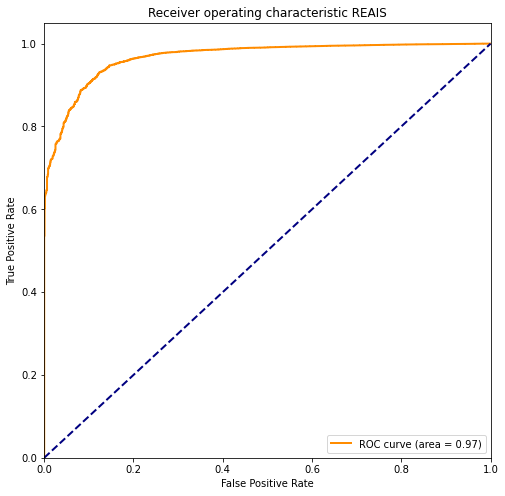

In [32]:
cria_curva_roc_auc(model,dictStftArrayFinal['murilo_1.edf']['array'],dictStftArrayFinal['murilo_1.edf']['target'][:,1])

In [33]:
limiar_escore(model,dictStftArrayFinal['murilo_1.edf']['array'],dictStftArrayFinal['murilo_1.edf']['target'][:,1])

Limiar que maxima especificidade e sensitividade:
[0.9896055459976196]
Precision 0.9979431094165454
Recall 0.9023224869964921
Acuracia 0.9023322750066763
F-Score 0.947727002024854
Roc-AUC 0.96726381570763


In [34]:
confusion_matrix(dictStftArrayFinal['murilo_1.edf']['target'][:,1], [1 if x >= 0.1 else 0 for x in y_pred[:,1]])

array([[  119,  1147],
       [   74, 66062]])

# Treino em Todos Menos  "remise_jean.edf"

In [35]:
tgt = None
stftArrayFinal = None

In [36]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'remise_jean.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [37]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(171752, 501, 4, 2)

In [38]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 2), 2)

In [39]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*5, kernel_size=(4,1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4,1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*10, kernel_size=(4,4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [40]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 501, 4, 2)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 249, 4, 160)       1440      
_________________________________________________________________
activation_6 (Activation)    (None, 249, 4, 160)       0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 62, 4, 160)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 62, 4, 160)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 59, 1, 320)        819520    
_________________________________________________________________
activation_7 (Activation)    (None, 59, 1, 320)       

In [41]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['AUC'])

In [42]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_remise.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['remise_jean.edf']['array'], dictStftArrayFinal['remise_jean.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
671/671 [==============================] - 117s 174ms/step - loss: 0.2473 - accuracy: 0.9060 - auc: 0.9647 - val_loss: 0.1296 - val_accuracy: 0.9694 - val_auc: 0.9920
Epoch 2/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0610 - accuracy: 0.9791 - auc: 0.9971 - val_loss: 0.1676 - val_accuracy: 0.9694 - val_auc: 0.9901
Epoch 3/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0475 - accuracy: 0.9827 - auc: 0.9981 - val_loss: 0.4029 - val_accuracy: 0.8118 - val_auc: 0.8960
Epoch 4/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0425 - accuracy: 0.9841 - auc: 0.9984 - val_loss: 0.5467 - val_accuracy: 0.7247 - val_auc: 0.8146
Epoch 5/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0387 - accuracy: 0.9855 - auc: 0.9986 - val_loss: 1.7309 - val_accuracy: 0.3072 - val_auc: 0.3034
Epoch 6/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0361 - accuracy: 0.9861 

In [43]:
model.save_weights("./modelo_remise.hdf5")

In [44]:
model.load_weights('./bestAutoSave_remise.hdf5')

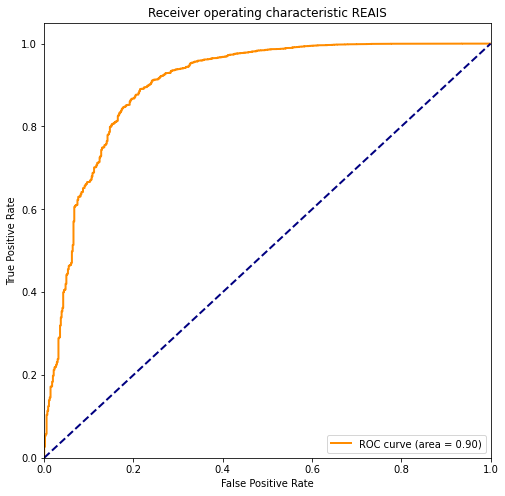

In [45]:
cria_curva_roc_auc(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

In [46]:
limiar_escore(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

Limiar que maxima especificidade e sensitividade:
[0.8851548433303833]
Precision 0.9932994780646072
Recall 0.8333136094674556
Acuracia 0.8332569857993587
F-Score 0.9063002767230839
Roc-AUC 0.9019492530110369


In [47]:
y_pred = model.predict(dictStftArrayFinal['remise_jean.edf']['array'])

In [48]:
confusion_matrix(dictStftArrayFinal['remise_jean.edf']['target'][:,1], [1 if x >= 0.08519119024276733 else 0 for x in y_pred[:,1]])

array([[  127,   437],
       [    7, 16893]])

In [49]:
pd.DataFrame(dictStftArrayFinal['remise_jean.edf']['target'])[1].value_counts()

1    16900
0      564
Name: 1, dtype: int64

FIM